<a href="https://colab.research.google.com/github/jaspersprakel/queueing_book/blob/master/notebooks/emas_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Assignment Data Science

**Introduction**

Over the past decade, platforms like Airbnb have transformed the way people travel, offering flexible and personalized alternatives to traditional hotel accommodations. With thousands of listings in major cities around the world, platforms like Airbnb not only facilitate short-term rentals but also generate a vast amount of user-generated data, including guest reviews. These reviews serve as a valuable source of insight, reflecting the quality of listings, guest satisfaction, and overall experiences.

In this project, the focus is on analyzing Airbnb listings in New York City with the goal of understanding the factors that influence a listing’s overall review score. The review score is a key indicator of listing quality and guest experience, and understanding what drives higher (or lower) scores can benefit both hosts and potential guests. For hosts, it offers guidance on how to improve their service and increase competitiveness; for guests, it helps in making informed booking decisions.

Using the Inside Airbnb dataset, a range of machine learning and statistical techniques are applied to explore which featuressuch as location, room type, host behavior, availability, and amenities are most predictive of review scores. Our analysis includes a combination of exploratory data analysis, data cleaning, feature engineering, and predictive modeling using methods such as logistic regression, decision trees, random forests, and XGBoost.

This analysis also aims to demonstrate how data science can be applied to real-world consumer platforms to extract meaningful insights from publicly available data. By identifying patterns in user behavior and listing characteristics, we provide a deeper understanding of what drives guest satisfaction in the sharing economy.

The remainder of this report covers the data preparation process, modeling approach, and evaluation of results, followed by a discussion of key takeaways, limitations, and suggestions for future work.

In [1]:
%%capture
!git clone https://github.com/ramonVDAKKER/teaching-data-science-emas
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!jupyter nbextension enable --py widgetsnbextension

**Import packages**

In [2]:
import os
print(os.getcwd())
os.chdir("teaching-data-science-emas/notebooks")

/content


Important packages for Python are <a href="http://www.numpy.org/">numpy</a> (for arrays, linear algebra, pseudorandom numbers etc.), <a href="http://pandas.pydata.org/">pandas</a> (contains convenient data structure called "pandas dataframe"), <a href="http://matplotlib.org/">matplotlib</a> & <a href="http://seaborn.pydata.org/"> seaborn</a> (for data visualisation), <a href="http://scikit-learn.org/stable/">sklearn</a> (scikit-learn; powerful package containing machine & statistical learning functions), and  <a href="https://www.statsmodels.org/stable/index.html">statsmodels</a> for statistical models and routines.

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix,  accuracy_score, roc_auc_score, precision_recall_curve, RocCurveDisplay
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import xgboost as xgb
#from xgboost import XGBRegressor
import io
from google.colab import files

In [4]:
%matplotlib inline

## 1. Load dataset & Elementary Data Analysis

### 1.1 Load and inspect data

Load dataset into a pandas dataframe:

In [5]:
uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded['listings 2.csv']))

Saving listings 2.csv to listings 2.csv


<ipython-input-5-be9cd142c138>:2: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(io.BytesIO(uploaded['listings 2.csv']))


The dataset is first split into a "train set" and a "validation set".

In [6]:
seed = 123
train_df, aux_df = train_test_split(dataset, train_size=.5, random_state=seed)
validation_df, test_df = train_test_split(aux_df, train_size=.5, random_state=seed)

print(f"data_train shape: {train_df.shape}")
print(f"data_validation shape: {validation_df.shape}")
print(f"data_test shape: {test_df.shape}")
del dataset

data_train shape: (18705, 74)
data_validation shape: (9352, 74)
data_test shape: (9353, 74)


Let us inspect the first 3 and the last 3 rows of the dataset:

In [ ]:
pd.options.display.max_columns = 100
display(train_df.head(3))
display(train_df.tail(3))

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
8133,12686241,https://www.airbnb.com/rooms/12686241,20220603182654,2022-06-04,Large Front Facing Bedroom & Private Backyard,Large bedroom on Garden floor with backyard ac...,NaN,https://a0.muscache.com/pictures/58451700-6447...,30848788,https://www.airbnb.com/users/show/30848788,Jamie,2015-04-08,"De Kalb, Mississippi, United States",NaN,within a few hours,90%,75%,f,https://a0.muscache.com/im/pictures/user/706a1...,https://a0.muscache.com/im/pictures/user/706a1...,Bedford-Stuyvesant,2.0,2.0,"['email', 'phone']",t,t,NaN,Bedford-Stuyvesant,Brooklyn,40.69462,-73.94693,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,"[""Essentials"", ""Cooking basics"", ""Wifi"", ""Carb...",$125.00,4,150,4.0,4.0,150.0,150.0,4.0,150.0,NaN,t,29,59,89,89,2022-06-04,51,1,0,2016-05-11,2022-04-27,4.69,4.75,4.69,4.94,4.98,4.57,4.59,NaN,f,2,0,2,0,0.69
24373,45261941,https://www.airbnb.com/rooms/45261941,20220603182654,2022-06-03,A+ Location Classic Studio Suite(2 Double Beds),Our apartment is located in the center of Manh...,This is a very central location where you can ...,https://a0.muscache.com/pictures/d415db7b-95f0...,348619646,https://www.airbnb.com/users/show/348619646,Nomad,2020-06-03,"New York, New York, United States",We are delighted to accommodate you during you...,within an hour,100%,99%,f,https://a0.muscache.com/im/pictures/user/00285...,https://a0.muscache.com/im/pictures/user/00285...,NaN,55.0,55.0,"['email', 'phone']",t,t,"New York, United States",Midtown,Manhattan,40.74797,-73.98847,Entire rental unit,Entire home/apt,4,NaN,1 bath,NaN,2.0,"[""Conditioner"", ""Essentials"", ""Washer"", ""Cooki...",$276.00,1,1125,1.0,10.0,1125.0,1125.0,3.3,1125.0,NaN,t,10,34,64,276,2022-06-03,41,33,1,2020-09-06,2022-05-20,4.49,4.37,4.54,4.61,4.88,4.85,4.46,NaN,t,54,39,15,0,1.93
35726,602777088581961008,https://www.airbnb.com/rooms/602777088581961008,20220603182654,2022-06-03,Sweet SoHo 1 Bedroom,(AC works!) The best location in NYC! Steps fr...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,236369220,https://www.airbnb.com/users/show/236369220,Andrea,2019-01-13,"New York, New York, United States",NaN,within a day,75%,46%,f,https://a0.muscache.com/im/pictures/user/bb833...,https://a0.muscache.com/im/pictures/user/bb833...,NaN,0.0,0.0,"['email', 'phone']",t,t,NaN,Nolita,Manhattan,40.72136,-73.99617,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Wine glasses"", ""Essentials"", ""Cooking basics...",$283.00,6,40,6.0,28.0,40.0,40.0,8.7,40.0,NaN,t,8,8,8,8,2022-06-03,6,6,2,2022-04-16,2022-05-24,4.83,4.83,4.83,4.83,4.83,4.83,4.83,NaN,f,1,1,0,0,3.67


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
17730,32549155,https://www.airbnb.com/rooms/32549155,20220603182654,2022-06-04,BK Home Away From Home,Charming 2 bedroom apartment on top floor of w...,"Home of Junior's Cheesecake, Coney Island, Bar...",https://a0.muscache.com/pictures/85873401-13c6...,244596528,https://www.airbnb.com/users/show/244596528,Mary Ann,2019-02-21,"Brooklyn, New York, United States","Born and raised in Brooklyn, New York. Gradua...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/69486...,https://a0.muscache.com/im/pictures/user/69486...,Bedford-Stuyvesant,1.0,1.0,"['email', 'phone']",t,t,"Brooklyn, New York, United States",Bedford-Stuyvesant,Brooklyn,40.69002,-73.934200,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Essentials"", ""Extra pillows and blankets"", ""...",$109.00,2,27,2.0,2.0,27.0,27.0,2.0,27.0,NaN,t,1,1,1,24,2022-06-04,116,50,4,2019-05-07,2022-05-27,4.78,4.86,4.82,4.98,4.91,4.69,4.84,NaN,f,1,1,0,0,3.09
28030,50152840,https://www.airbnb.com/rooms/50152840,20220603182654,2022-06-04,A lovely smart home in Williamsburg-Greenpoint,Stay in a sun-filled apartment with smart-home...,North Brooklyn (Greenpoint/Williamsburg) – the...,https://a0.muscache.com/pictures/22f41221-7b98...,6796668,https://www.airbnb.com/users/show/6796668,Milan,2013-06-08,"New York, New York, United States",I’m a New York based design and branding profe...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/9934d...,https://a0.muscache.com/im/pictures/user/9934d...,Williamsburg,1.0,1.0,"['email', 'phone']",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71941,-73.943146,Entire condo,Entire home/apt,2,NaN,1 bath,1.0,2.0,"[""Baby monitor"", ""Table corner guards"", ""Wine ...",$200.00,31,365,31.0,31.0,365.0,365.0,31.0,365.0,NaN,t,0,0,0,69,2022-06-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
15725,28220182,https://www.airbnb.com/rooms/28220182,20220603182654,2022-06-04,New Charming 1 Bedroom Oasis Apartment,A Newly renovated fully furnished one bedroom ...,The neighborhood is historic and surrounded by...,https://a0.muscache.com/pictures/38fa5d92-4957...,35387196,https://www.airbnb.com/users/show/35387196,Kizzie,2015-06-09,"Brooklyn, New York, United States",NaN,within a few hours,80%,75%,f,https://a0.muscache.com/im/pictures/user/93ed6...,https://a0.muscache.com/im/pictures/user/93ed6...,Crown Heights,2.0,2.0,"['email', 'phone', 'work_email']",t,t,"Brooklyn, New York, United States",Prospect-Lefferts Gardens,Brooklyn,40.66130,-73.953650,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Carbon monoxide alarm"", ""Heating"", ""Essentia...",$110.00,7,365,7.0,7.0,365.0,365.0,7.0,365.0,NaN

Some meta-data:

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18705 entries, 8133 to 15725
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            18705 non-null  int64  
 1   listing_url                                   18705 non-null  object 
 2   scrape_id                                     18705 non-null  int64  
 3   last_scraped                                  18705 non-null  object 
 4   name                                          18699 non-null  object 
 5   description                                   18266 non-null  object 
 6   neighborhood_overview                         11155 non-null  object 
 7   picture_url                                   18705 non-null  object 
 8   host_id                                       18705 non-null  int64  
 9   host_url                                      18705 non-null  o

See link below for a description of the columns.

https://www.kaggle.com/datasets/dominoweir/inside-airbnb-nyc?select=listings+2.csv

## 1.1 Summary statistics

In [ ]:
train_df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.870500e+04,1.870500e+04,1.870500e+04,18678.00000,18678.00000,18705.000000,18705.000000,18705.000000,0.0,16891.000000,18258.000000,18705.000000,1.870500e+04,18698.000000,18698.000000,1.869800e+04,1.869800e+04,18698.000000,1.869800e+04,0.0,18705.000000,18705.000000,18705.000000,18705.000000,18705.000000,18705.000000,18705.000000,14777.000000,14524.000000,14531.000000,14521.000000,14527.000000,14519.000000,14519.000000,18705.000000,18705.000000,18705.000000,18705.000000,14777.000000
mean,6.036603e+16,2.022060e+13,1.229774e+08,61.88275,61.88275,40.729352,-73.946139,2.886234,NaN,1.349239,1.628053,19.825982,1.689919e+03,20.538293,27.511285,1.609759e+06,3.447383e+06,26.956974,2.460680e+06,NaN,4.669607,12.763111,23.434162,118.674739,26.004812,7.150922,0.748196,4.605712,4.742139,4.619499,4.813230,4.804369,4.745772,4.643509,15.002887,9.251911,5.620957,0.053836,1.147048
std,1.797305e+17,1.902395e+00,1.372348e+08,393.59663,393.59663,0.058142,0.056978,1.934833,NaN,0.733566,1.145854,33.249508,1.462313e+05,41.963464,79.123872,5.874166e+07,8.595202e+07,77.234696,6.704375e+07,NaN,8.177008,18.598467,29.536626,132.660181,53.921664,18.351724,1.775041,0.773487,0.482023,0.560597,0.418888,0.448629,0.405130,0.504071,50.470021,45.107521,23.839727,0.519034,1.800730
min,2.595000e+03,2.022060e+13,2.438000e+03,0.00000,0.00000,40.508630,-74.266750,0.000000,NaN,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.422859e+07,2.022060e+13,1.263910e+07,1.00000,1.00000,40.688420,-73.983600,2.000000,NaN,1.000000,1.000000,2.000000,6.000000e+01,2.000000,3.000000,3.600000e+02,3.650000e+02,2.000000,3.650000e+02,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.570000,4.700000,4.500000,4.800000,4.800000,4.670000,4.550000,1.000000,0.000000,0.000000,0.000000,0.120000
50%,3.439381e+07,2.022060e+13,5.435116e+07,1.00000,1.00000,40.724900,-73.953910,2.000000,NaN,1.000000,1.000000,30.000000,3.650000e+02,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,NaN,0.000000,0.000000,6.000000,58.000000,5.000000,0.000000,0.000000,4.820000,4.890000,4.800000,4.950000,4.960000,4.860000,4.770000,1.000000,1.000000,0.000000,0.000000,0.480000
75%,4.989833e+07,2.022060e+13,2.069725e+08,3.00000,3.00000,40.763250,-73.926760,4.000000,NaN,1.000000,2.000000,30.000000,1.125000e+03,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,NaN,6.000000,23.000000,44.000000,251.000000,25.000000,6.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.960000,3.000000,1.000000,1.000000,0.000000,1.600000
max,6.412414e+17,2.022060e+13,4.623937e+08,3404.00000,3404.00000,40.928340,-73.704260,16.000000,NaN,15.000000,42.000000,1250.000000,2.000000e+07,1250.000000,1250.000000,2.147484e+09,2.147484e+09,1250.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,1419.000000,909.000000,72.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,391.000000,391.000000,190.000000,11.000000,68.580000


## 1.2 Cleansing

Check for missing values:

In [ ]:
train_df.isnull().sum()[train_df.isnull().sum() > 0]

,0
name,6
description,439
neighborhood_overview,7550
host_name,27
host_since,27
host_location,77
host_about,8257
host_response_time,6687
host_response_rate,6687
host_acceptance_rate,5941


List all the variables in the dataset:

In [ ]:
print(train_df.columns.tolist())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 

Selecting the columns relevant for the analysis:

In [7]:
columns_to_keep = ['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
train_df = train_df[columns_to_keep]
print(train_df.columns.tolist())
len(train_df.columns)

['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_li

48

## 1.3 Univariate plots

Distribution target variable:

Recall, that we are interested in the review_scores_rating for a rental from AirBnB.
The distribution of the target in the train set:


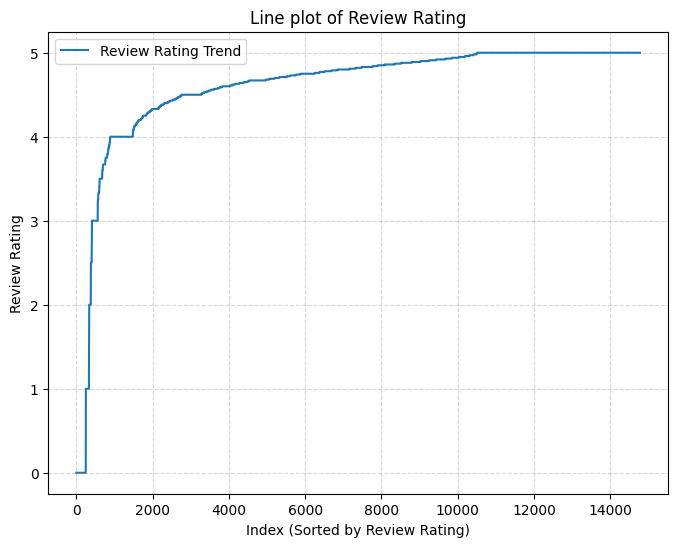

,review_scores_rating
count,14777.000000
mean,4.605712
std,0.773487
min,0.000000
25%,4.570000
50%,4.820000
75%,5.000000
max,5.000000


In [ ]:
print("Recall, that we are interested in the review_scores_rating for a rental from AirBnB.")
print("The distribution of the target in the train set:")
# Sort prices for a line plot
sorted_review_ratings = np.sort(train_df["review_scores_rating"].values)

# Create a line plot
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(sorted_review_ratings, label="Review Rating Trend")
plt.xlabel("Index (Sorted by Review Rating)")
plt.ylabel("Review Rating")
plt.title("Line plot of Review Rating")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

train_df["review_scores_rating"].describe()

In [8]:
print(f"The data type of the prices is {type(train_df['review_scores_rating'].loc[0])}\n")
print("This is because the prices include a $ sign. Therefore we should remove these and convert the data to numerical.")
train_df["price"] = train_df["price"].str.replace("$", "").str.replace(",", "").astype(float)
print(f"The data type of the target is now {type(train_df['price'].loc[0])}\n")
train_df["review_scores_rating"].describe()

print(f"From the description table, we find that there are some rentals with a price of 0, namely {(train_df['price'] == 0).sum()}.")
print(f"Looking closer at these {(train_df['price'] == 0).sum()} observations, we find that they have quite some missing data as well as no availability for the coming 365 days.")
print("As the price of 0 does not seem reasonable, these observations are excluded from the analysis as they will not provide any helpful insights.")

train_df[train_df["price"] == 0]

The data type of the prices is <class 'numpy.float64'>

This is because the prices include a $ sign. Therefore we should remove these and convert the data to numerical.
The data type of the target is now <class 'numpy.float64'>

From the description table, we find that there are some rentals with a price of 0, namely 12.
Looking closer at these 12 observations, we find that they have quite some missing data as well as no availability for the coming 365 days.
As the price of 0 does not seem reasonable, these observations are excluded from the analysis as they will not provide any helpful insights.


,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
22655,42384501,262458398,2019-05-17,"New York, New York, United States",within an hour,100%,100%,f,2.0,"['email', 'phone', 'work_email']",...,4.69,4.45,4.73,4.41,f,1,0,0,0,2.56
22318,41740615,268417148,2019-06-13,"New York, New York, United States",within an hour,100%,100%,f,0.0,"['email', 'phone', 'work_email']",...,4.33,4.30,4.65,4.35,f,1,0,0,0,1.27
23310,43247386,335072254,2020-02-10,US,within an hour,100%,87%,f,5.0,"['email', 'phone']",...,4.21,4.00,4.71,3.71,f,1,0,0,0,1.15
26310,48089897,261016212,2019-05-10,US,within an hour,100%,0%,f,10.0,"['email', 'phone']",...,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN
22604,42279171,265458818,2019-05-31,"New York, New York, United States",within an hour,100%,98%,f,6.0,"['email', 'phone']",...,4.66,4.59,4.66,4.50,f,1,0,0,0,9.08
26510,48325676,390077597,2021-02-25,US,within an hour,100%,90%,f,0.0,"['email', 'phone']",...,5.00,5.00,5.00,4.00,f,1,0,0,0,0.23
25093,46251446,374516933,2020-11-05,"New York, New York, United States",within an hour,100%,72%,t,0.0,"['email', 'phone']",...,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN
22494,42065543,307634016,2019-11-06,"New York, New York, United States",within an hour,100%,100%,f,4.0,"['email', 'phone']",...,4.87,4.86,4.89,4.61,f,1,0,0,0,16.34
23197,43078550,334334264,2020-02-07,US,NaN,NaN,NaN,f,0.0,['phone'],...,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN
22584,42228997,314197504,2019-12-03,US,NaN,NaN,NaN,f,0.0,"['email', 'phone', 'work_email']",...,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN


In [9]:
train_df = train_df[train_df['price'] != 0]

The host_response_rate and the host_acceptance_rate show a special character, making them non numeric. Therefore a similar transformation to the price variable should be performed to make them numeric, to apply them in further analysis.

In [10]:
train_df["host_response_rate"] = train_df["host_response_rate"].str.replace("%", "").astype(float)
train_df["host_acceptance_rate"] = train_df["host_acceptance_rate"].str.replace("%", "").astype(float)

Some of the variables in the dataset are dates. To use these in the analyses these should be converted to numeric values. As the data was scraped from AirBnB on 04/06/2022, we will compute the difference with this date as follows:

In [31]:
date_var = ['host_since', 'first_review', 'last_review']
reference_date = pd.to_datetime('04/06/2022', format='%d/%m/%Y')

for var in date_var:
    train_df[var] = pd.to_datetime(train_df[var], format='%d/%m/%Y', errors='coerce')
    train_df[var + '_day'] = (reference_date - train_df[var]).dt.days

In [32]:
print(train_df.columns.tolist())

['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_li

In [11]:
num_var = ['review_scores_rating', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
cat_var = ['host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable']

Histograms for numerical variables:

array([[<Axes: title={'center': 'review_scores_rating'}>,
        <Axes: title={'center': 'host_response_rate'}>,
        <Axes: title={'center': 'host_acceptance_rate'}>,
        <Axes: title={'center': 'host_listings_count'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'accommodates'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'minimum_nights_avg_ntm'}>,
        <Axes: title={'center': 'maximum_nights_avg_ntm'}>,
        <Axes: title={'center': 'availability_30'}>,
        <Axes: title={'center': 'availability_60'}>,
        <Axes: title={'center': 'availability_90'}>],
       [<Axes: title={'center': 'availability_365'}>,
        <Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'number_of_reviews_ltm'}>,
        <Axes: title={'center': 'number_of_revi

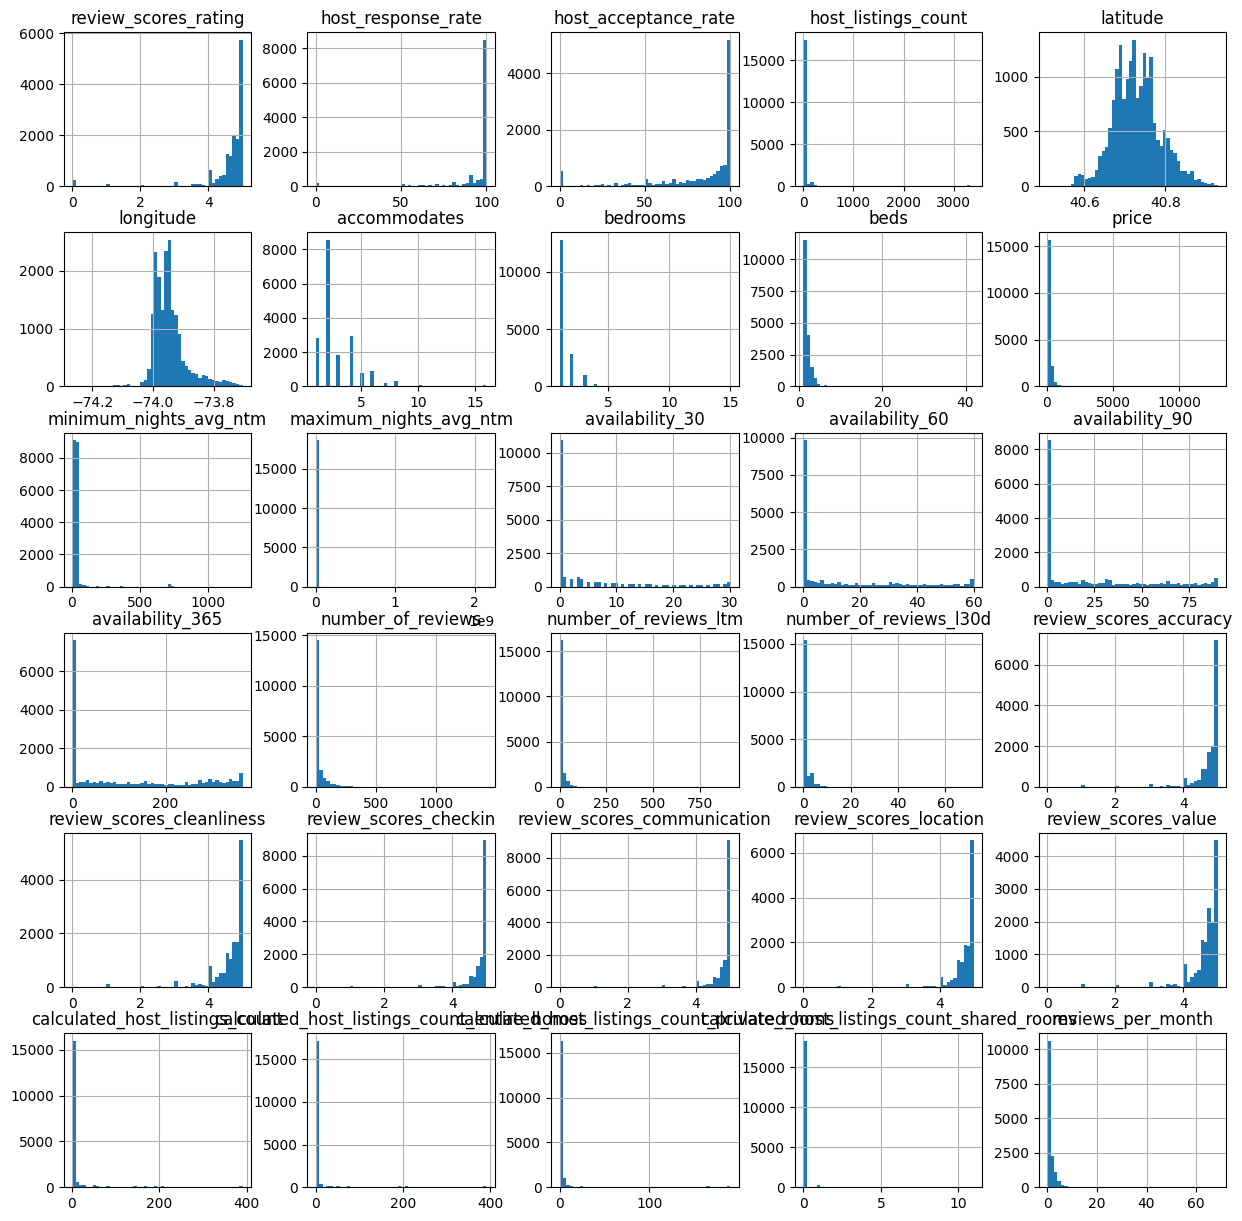

In [ ]:
train_df[num_var].hist(bins=50, figsize=(15, 15))

Bar plots for categorical variables:

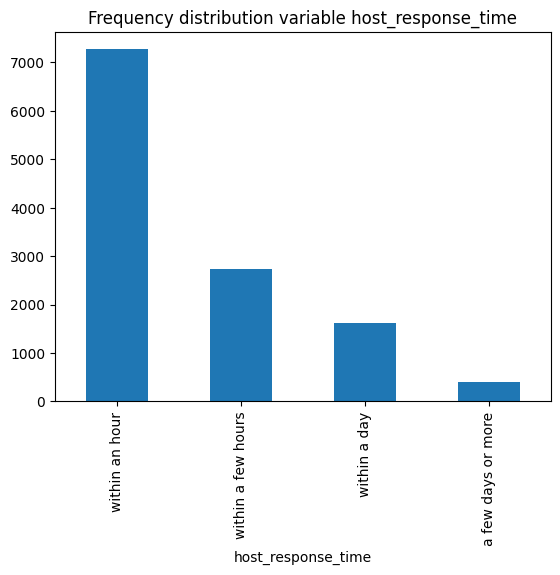

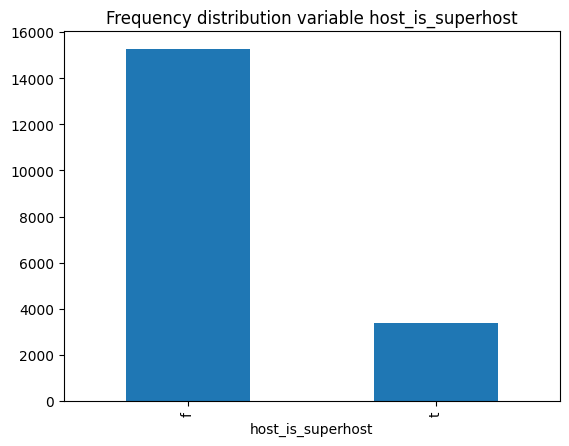

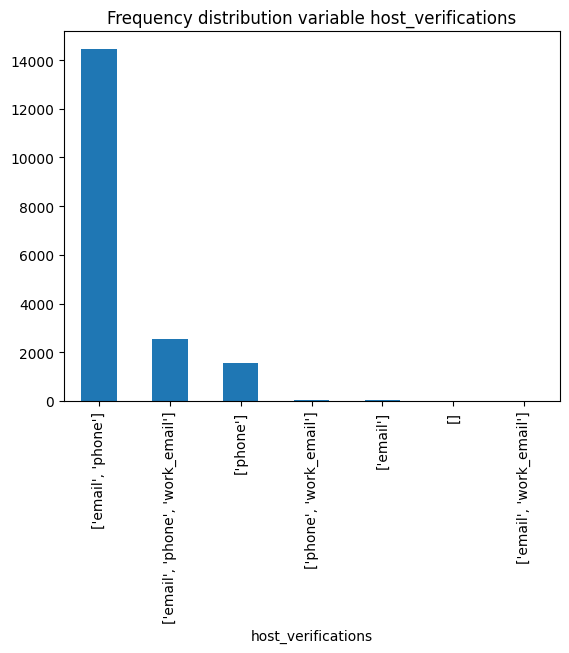

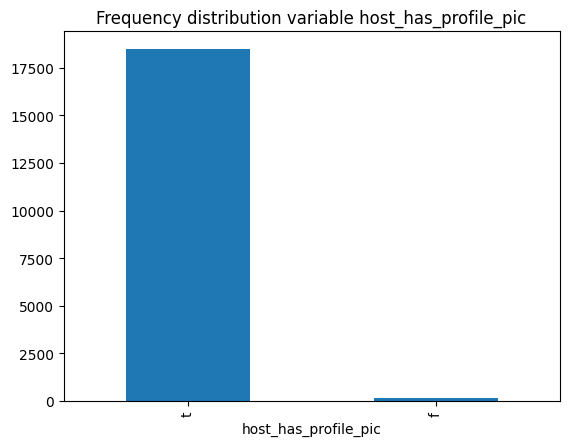

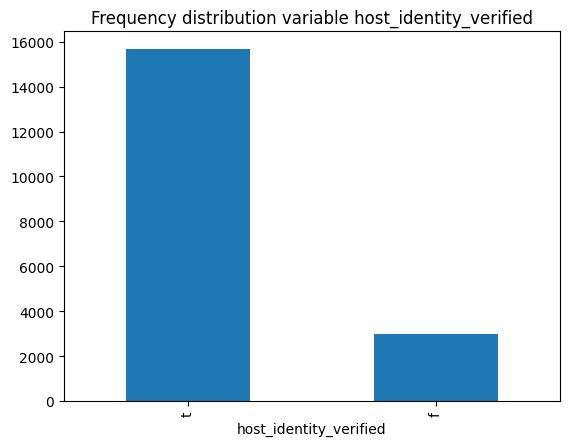

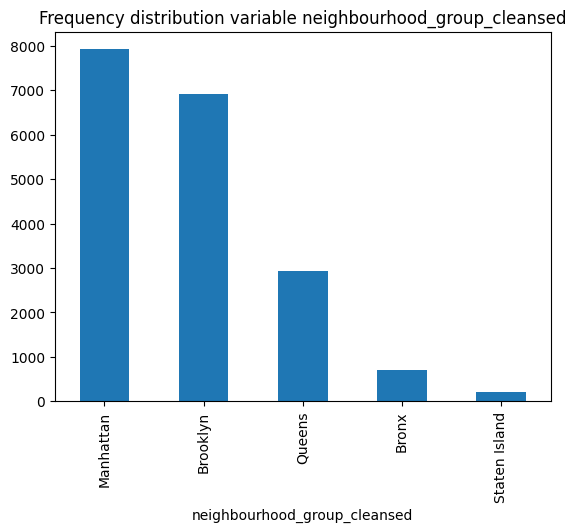

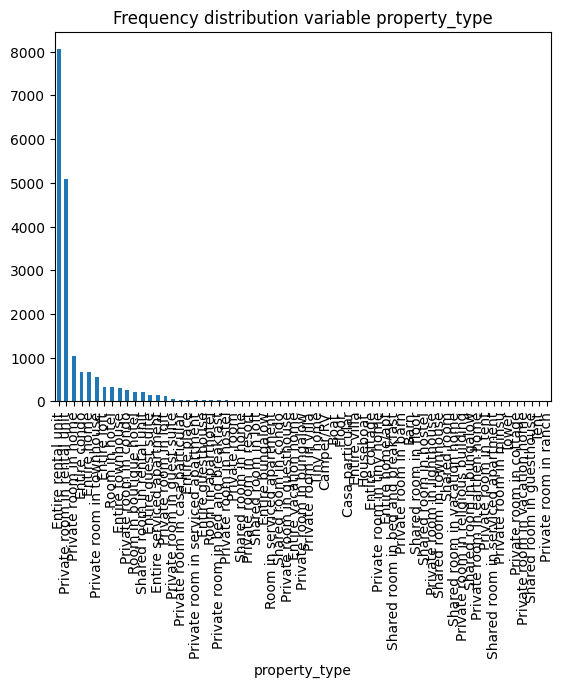

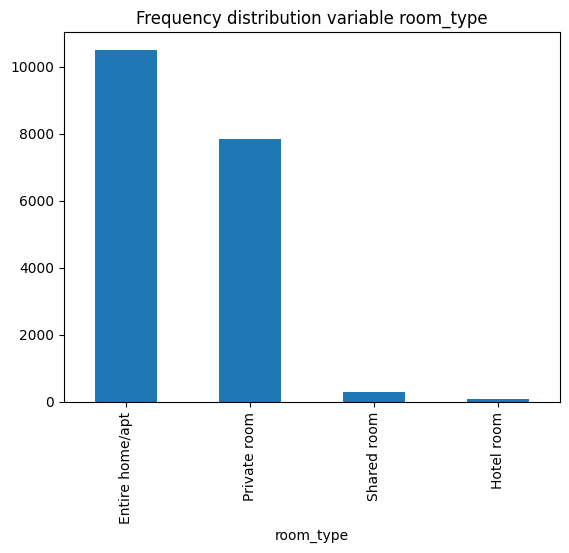

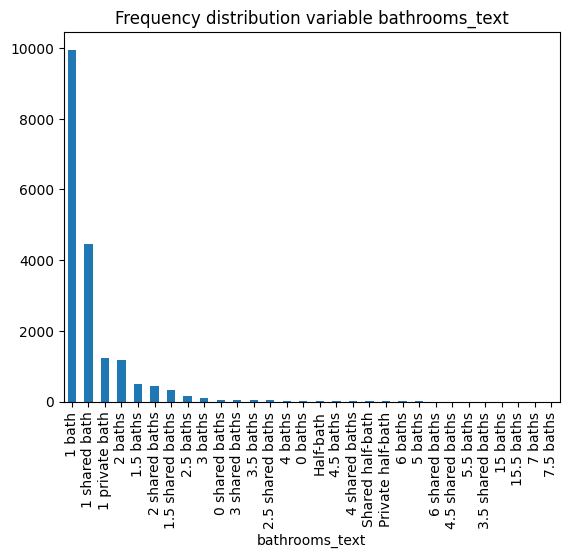

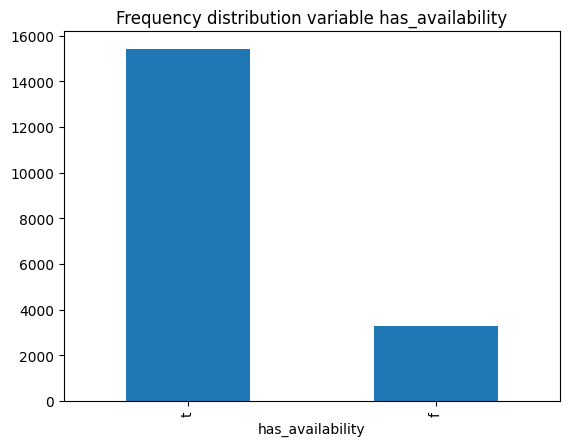

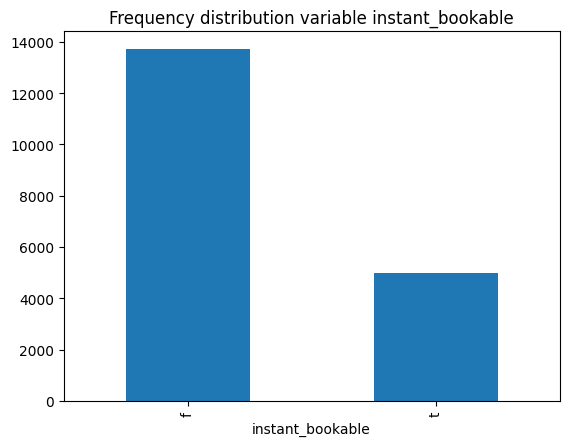

In [ ]:
for var in cat_var:
    train_df[var].value_counts().plot(kind="bar", title=f"Frequency distribution variable {var}")
    plt.show()

### 1.4 Bivariate plots

Correlation between variables:

In [ ]:
train_df[num_var].corr(method="pearson")

,review_scores_rating,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
review_scores_rating,1.000000,0.106215,0.039546,-0.013754,-0.045547,0.009887,0.028731,0.021707,0.024613,0.028364,-0.048270,-0.000865,0.009642,0.029000,0.043658,0.058722,0.101573,0.082082,0.091650,0.827404,0.772233,0.698175,0.745192,0.592273,0.831304,-0.033273,0.006424,-0.069794,-0.035927,0.101169
host_response_rate,0.106215,1.000000,0.474046,0.064751,-0.023790,0.054282,0.043701,0.020372,0.050376,-0.033441,0.019388,-0.001795,-0.042634,-0.013413,-0.018891,-0.028482,0.089394,0.126473,0.159010,0.063955,0.085977,0.067511,0.093938,0.029170,0.078158,0.038448,0.015570,0.051606,0.016083,0.148215
host_acceptance_rate,0.039546,0.474046,1.000000,0.050858,-0.007050,0.082741,0.065990,0.010220,0.042212,0.008965,0.005126,0.022639,0.071933,0.103449,0.105258,0.080578,0.139772,0.224882,0.245482,0.004361,0.047953,0.014793,0.014463,-0.008220,0.019249,0.084728,0.064881,0.053750,0.030150,0.267986
host_listings_count,-0.013754,0.064751,0.050858,1.000000,0.037225,-0.091210,-0.001393,0.004090,-0.013282,0.124435,0.806762,-0.005085,0.074354,0.084626,0.093459,0.140747,-0.068704,-0.050202,-0.054960,-0.036850,-0.018649,-0.005877,-0.053163,0.014550,-0.084554,0.753655,0.763832,0.150956,-0.014663,-0.026284
latitude,-0.045547,-0.023790,-0.007050,0.037225,1.000000,0.049417,-0.056917,-0.075584,-0.066941,0.026464,0.044483,0.013467,-0.013647,-0.019470,-0.015457,-0.002184,-0.031409,-0.034675,-0.031882,-0.052364,-0.052302,-0.053363,-0.058791,-0.002494,-0.064262,0.070396,0.052814,0.047340,0.030122,-0.034813
longitude,0.009887,0.054282,0.082741,-0.091210,0.049417,1.000000,-0.002021,0.009102,0.014823,-0.125135,-0.099629,-0.014716,0.151310,0.169561,0.162542,0.098145,0.051176,0.055610,0.079410,-0.007304,0.010579,-0.003300,-0.012641,-0.136117,0.000333,-0.062846,-0.121967,0.099127,0.026290,0.095461
accommodates,0.028731,0.043701,0.065990,-0.001393,-0.056917,-0.002021,1.000000,0.744916,0.760423,0.322877,-0.048657,-0.007441,0.116999,0.103867,0.111698,0.139361,0.052814,0.076388,0.073252,-0.002875,0.038486,0.008669,0.004573,-0.014822,-0.006094,-0.056768,-0.008162,-0.102700,-0.058126,0.090499
bedrooms,0.021707,0.020372,0.010220,0.004090,-0.075584,0.009102,0.744916,1.000000,0.778666,0.274073,-0.014345,-0.017639,0.042640,0.037593,0.055227,0.104551,0.002746,0.033177,0.033625,-0.001239,0.033951,0.014164,0.010816,-0.012274,-0.001073,-0.038027,0.008527,-0.086652,-0.047697,0.035966
beds,0.024613,0.050376,0.042212,-0.013282,-0.066941,0.014823,0.760423,0.778666,1.000000,0.256145,-0.050763,-0.008558,0.085791,0.076586,0.087382,0.121168,0.056445,0.062726,0.064329,-0.000088,0.033672,0.015892,0.010384,-0.015594,0.001552,-0.072368,-0.036324,-0.084138,0.007025,0.067844
price,0.028364,-0.033441,0.008965,0.124435,0.026464,-0.125135,0.322877,0.274073,0.256145,1.000000,0.078624,0.025377,0.175002,0.157392,0.152768,0.116152,-0.033698,-0.003245,-0.011021,0.008254,0.044225,-0.000844,0.006718,0.065921,-0.006676,0.068559,0.095874,-0.037210,-0.027061,0.016521


<ipython-input-27-0f4783709a0e>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("jet", 30)


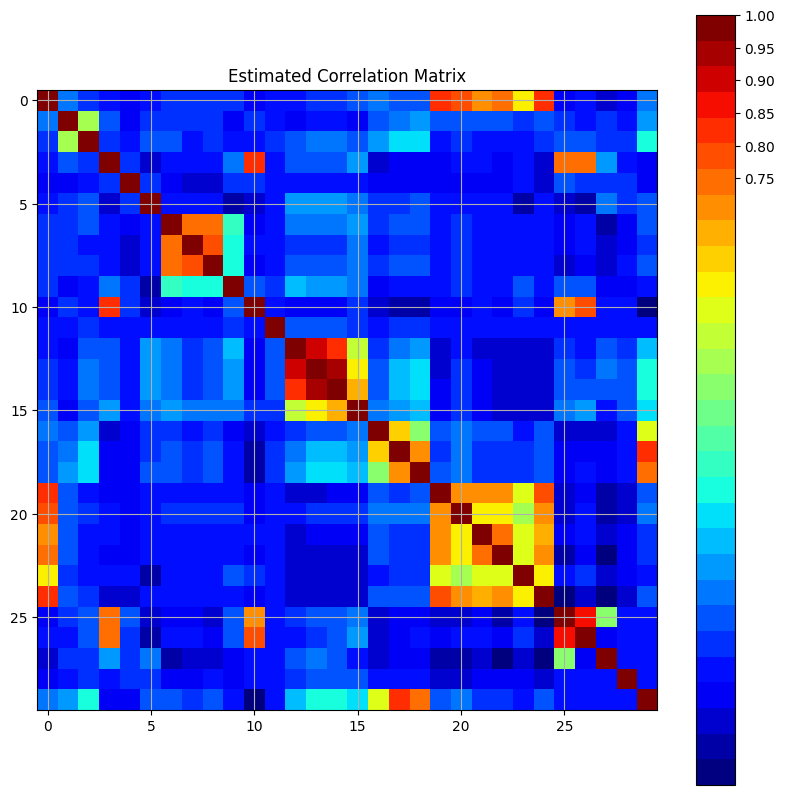

                                    Name feature
0                           review_scores_rating
1                             host_response_rate
2                           host_acceptance_rate
3                            host_listings_count
4                                       latitude
5                                      longitude
6                                   accommodates
7                                       bedrooms
8                                           beds
9                                          price
10                        minimum_nights_avg_ntm
11                        maximum_nights_avg_ntm
12                               availability_30
13                               availability_60
14                               availability_90
15                              availability_365
16                             number_of_reviews
17                         number_of_reviews_ltm
18                        number_of_reviews_l30d
19                  

In [ ]:
def VizCorrelationMatrix(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap("jet", 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title("Estimated Correlation Matrix")
    fig.colorbar(cax, ticks=[.75, .8, .85, .90, .95, 1])
    plt.show()
VizCorrelationMatrix(train_df[num_var])
print(pd.DataFrame(num_var, columns=["Name feature"]))

Plots of the relation between price and numerical variable X:

Consider feature host_response_rate:


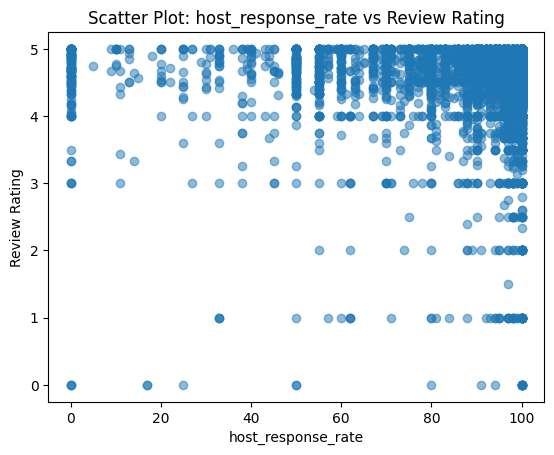

Consider feature host_acceptance_rate:


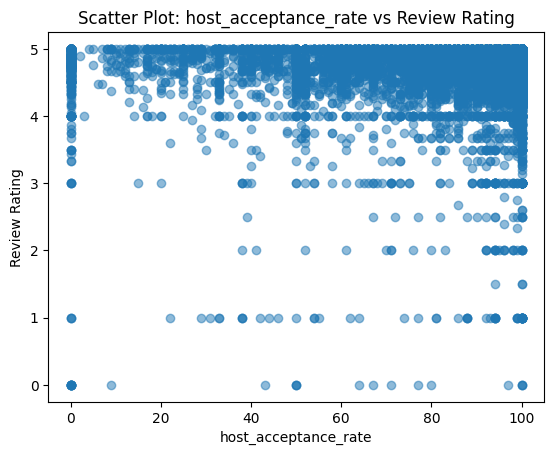

Consider feature host_listings_count:


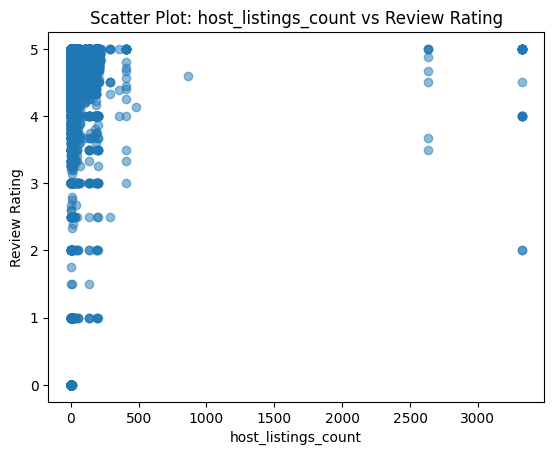

Consider feature latitude:


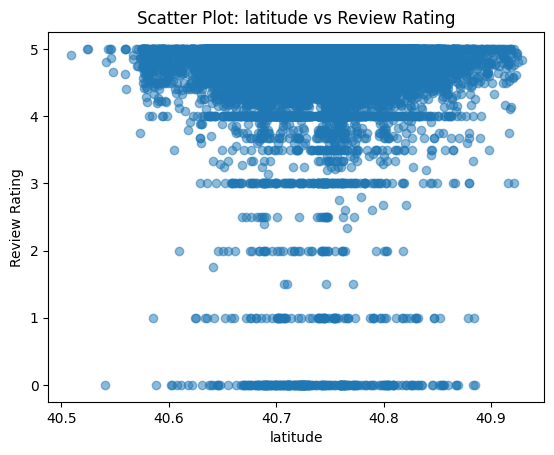

Consider feature longitude:


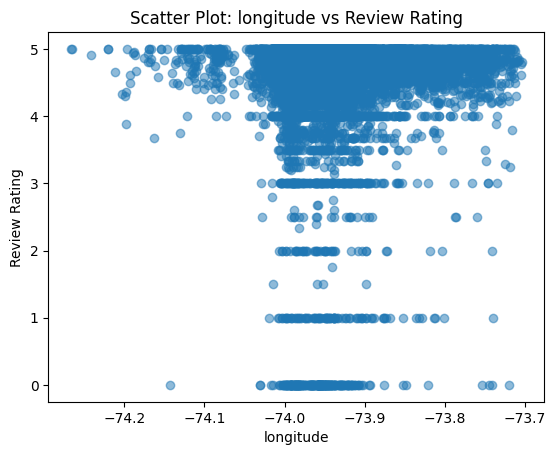

Consider feature accommodates:


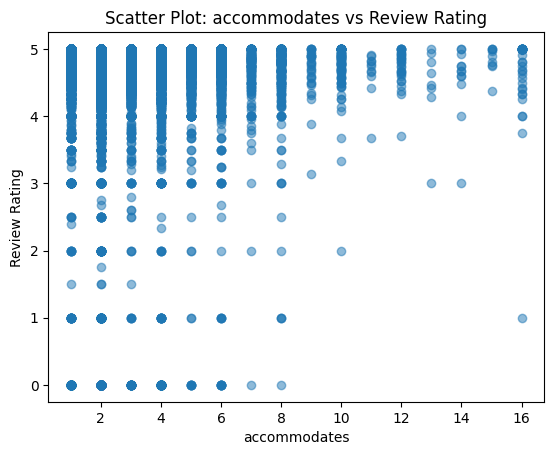

Consider feature bedrooms:


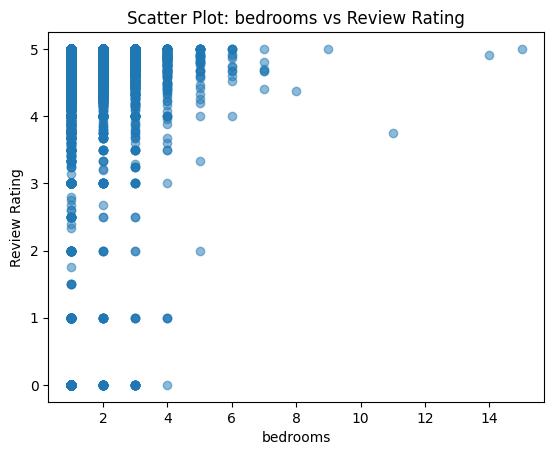

Consider feature beds:


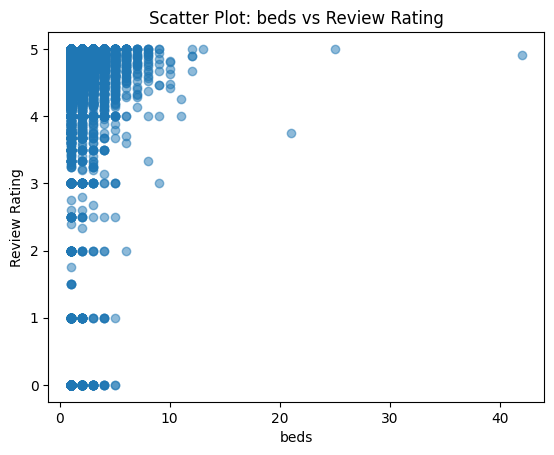

Consider feature price:


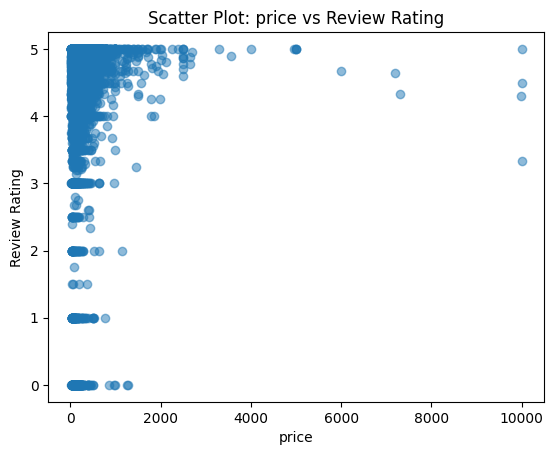

Consider feature minimum_nights_avg_ntm:


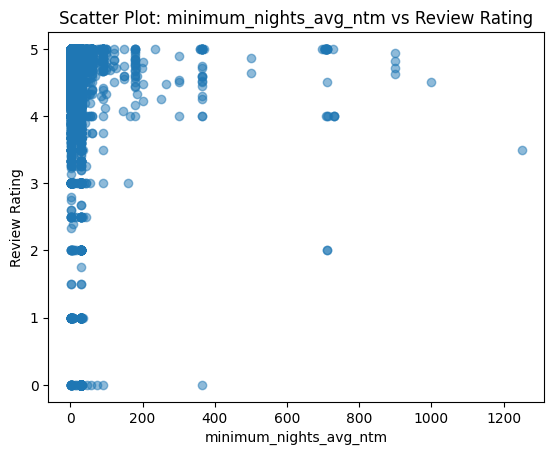

Consider feature maximum_nights_avg_ntm:


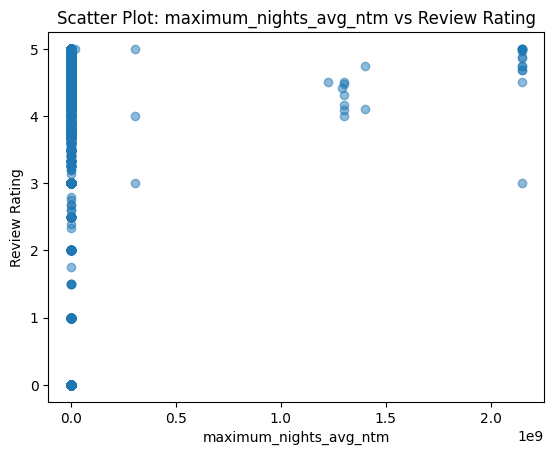

Consider feature availability_30:


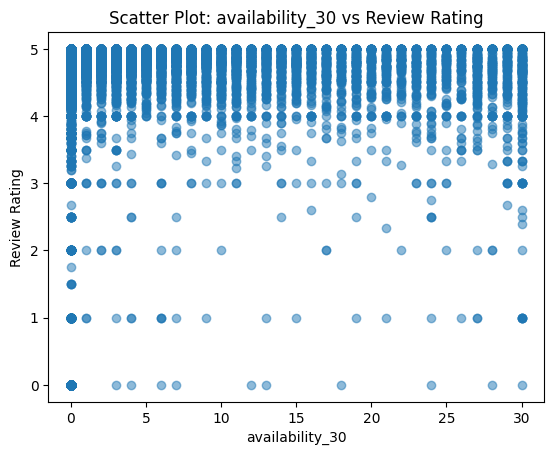

Consider feature availability_60:


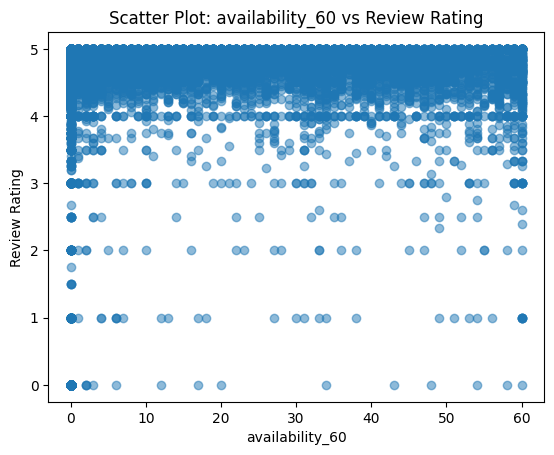

Consider feature availability_90:


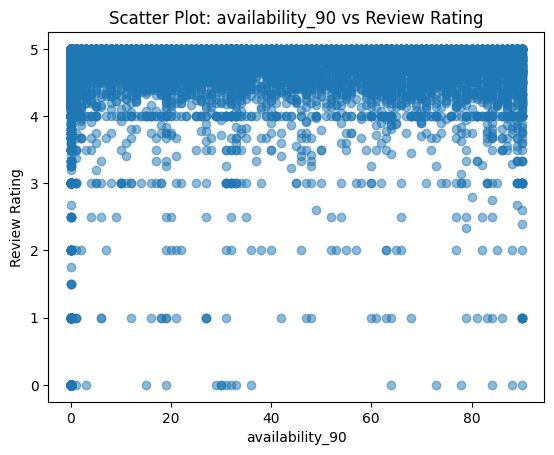

Consider feature availability_365:


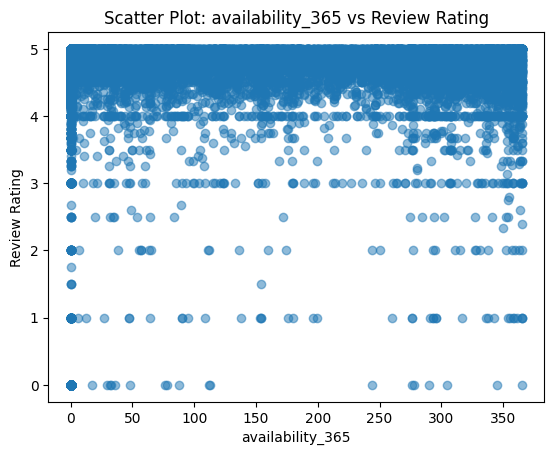

Consider feature number_of_reviews:


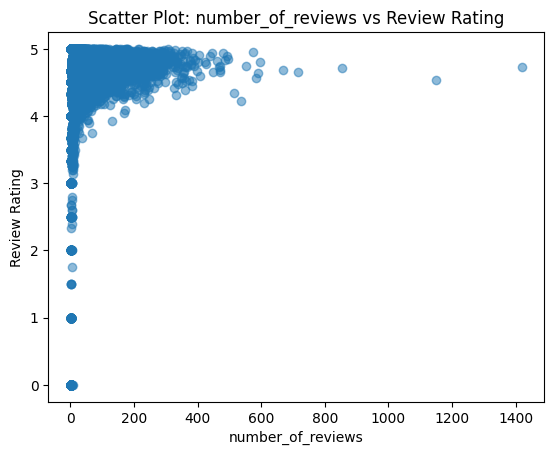

Consider feature number_of_reviews_ltm:


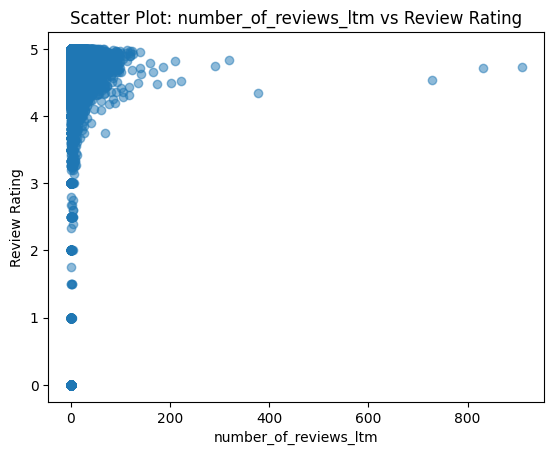

Consider feature number_of_reviews_l30d:


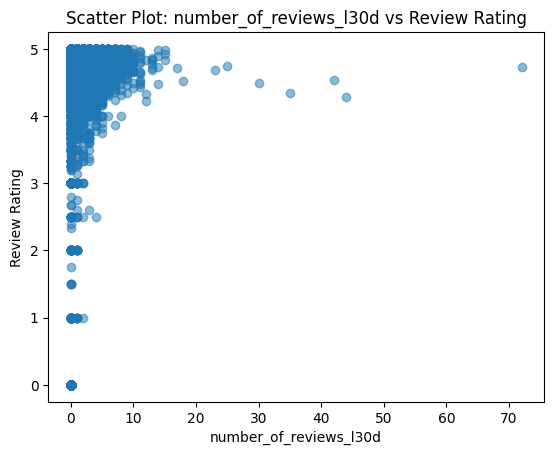

Consider feature review_scores_accuracy:


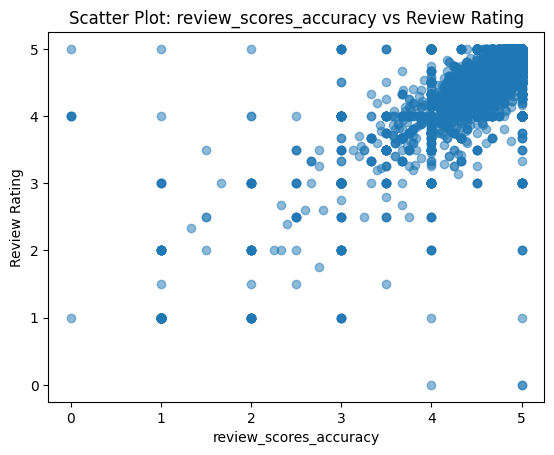

Consider feature review_scores_cleanliness:


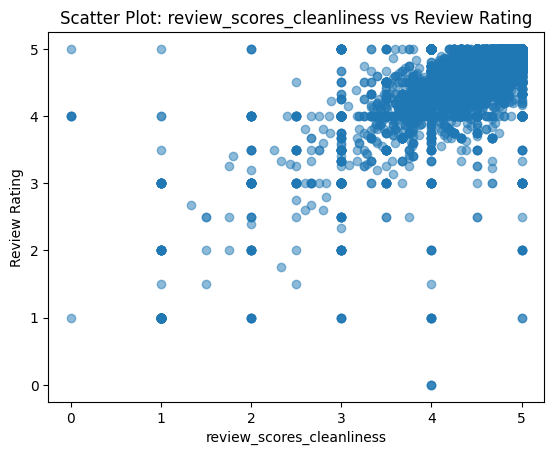

Consider feature review_scores_checkin:


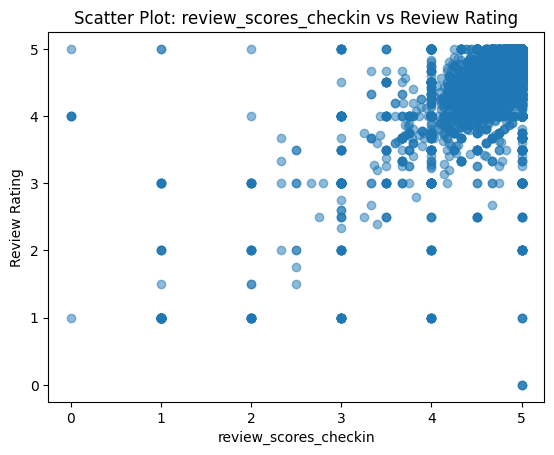

Consider feature review_scores_communication:


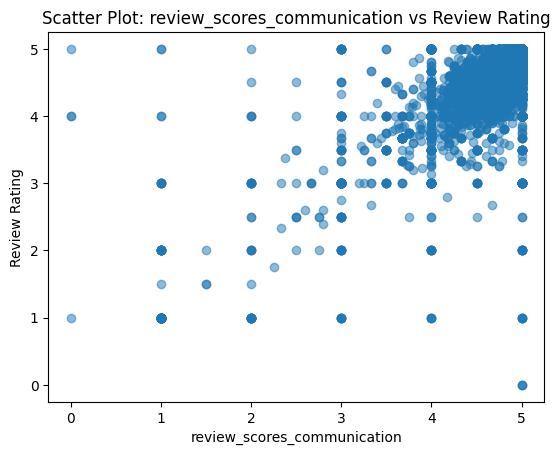

Consider feature review_scores_location:


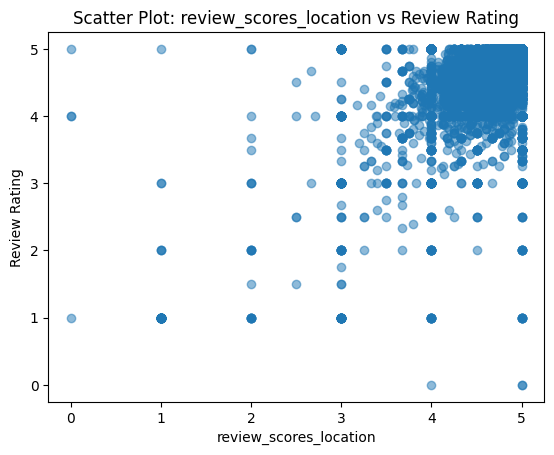

Consider feature review_scores_value:


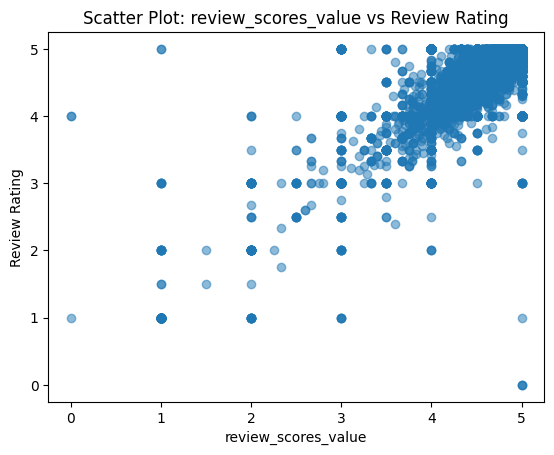

Consider feature calculated_host_listings_count:


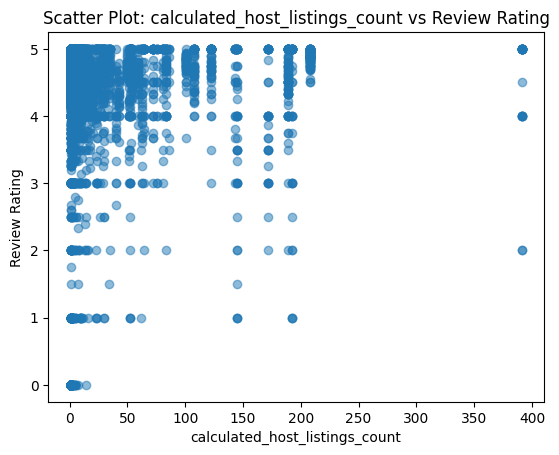

Consider feature calculated_host_listings_count_entire_homes:


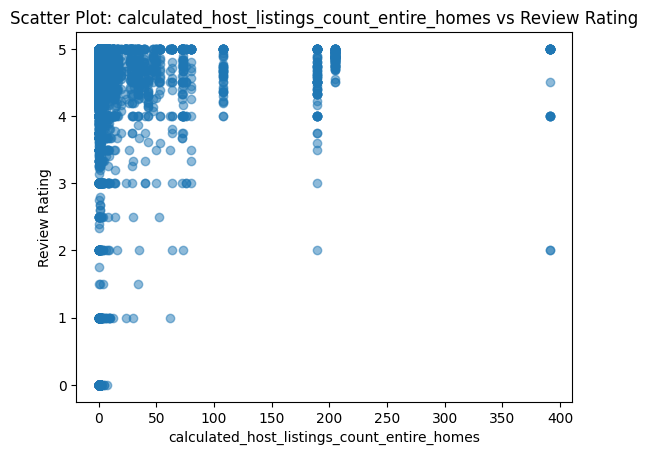

Consider feature calculated_host_listings_count_private_rooms:


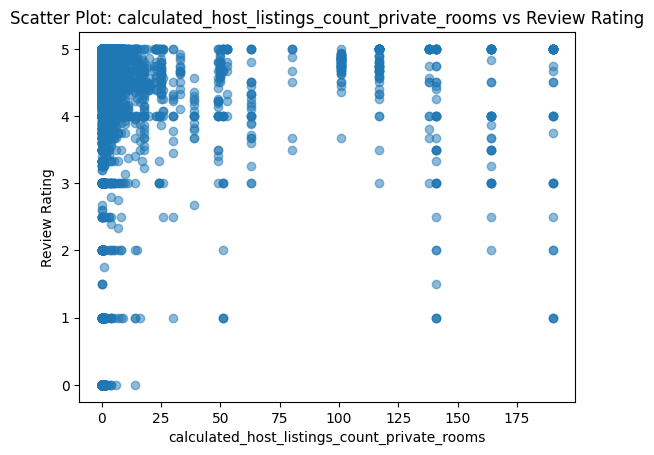

Consider feature calculated_host_listings_count_shared_rooms:


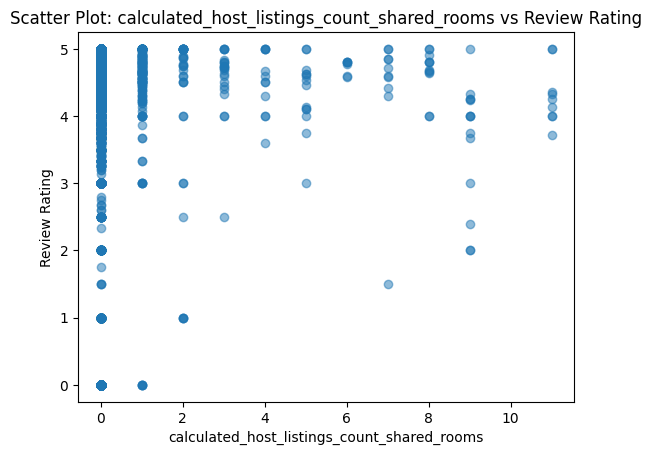

Consider feature reviews_per_month:


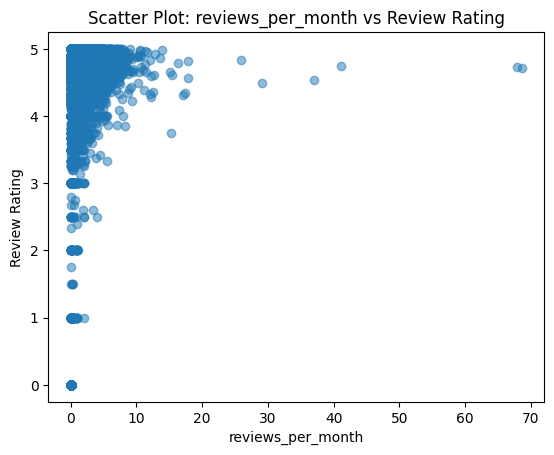

In [ ]:
plot_var = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

Z = train_df.copy()
for name in plot_var:
    print("Consider feature " + name + ":")
    plt.scatter(Z[name], Z["review_scores_rating"], alpha=0.5)
    plt.xlabel(name)
    plt.ylabel("Review Rating")
    plt.title(f"Scatter Plot: {name} vs Review Rating")
    plt.show()

Box plot between the price and the categorical variables:

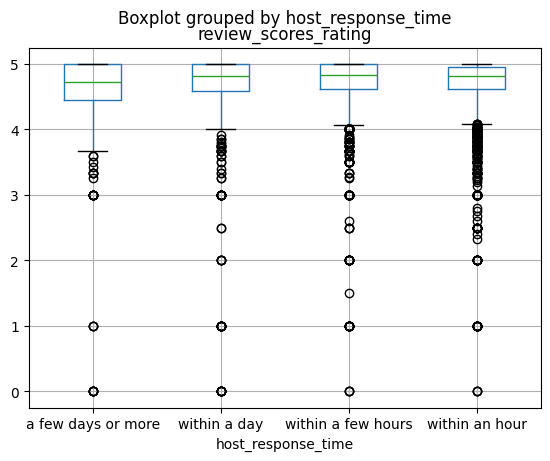

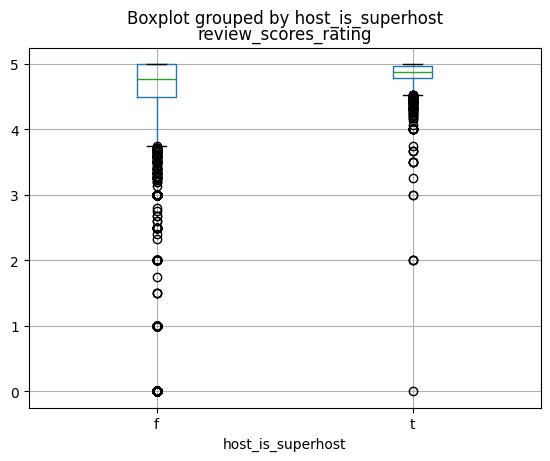

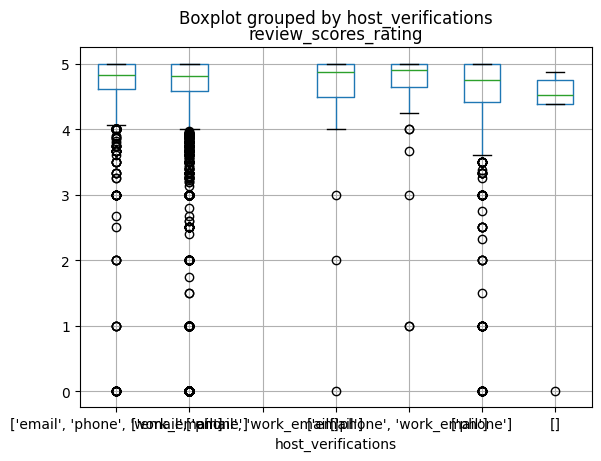

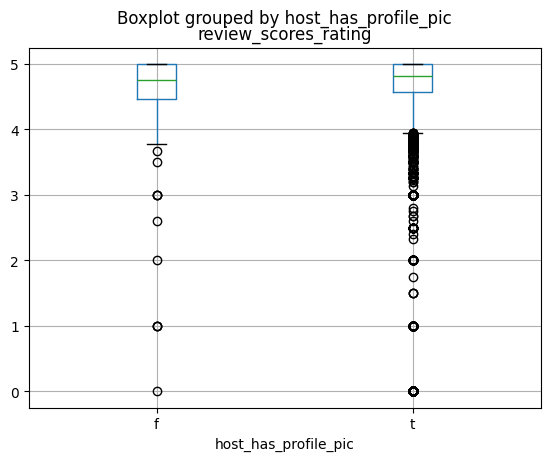

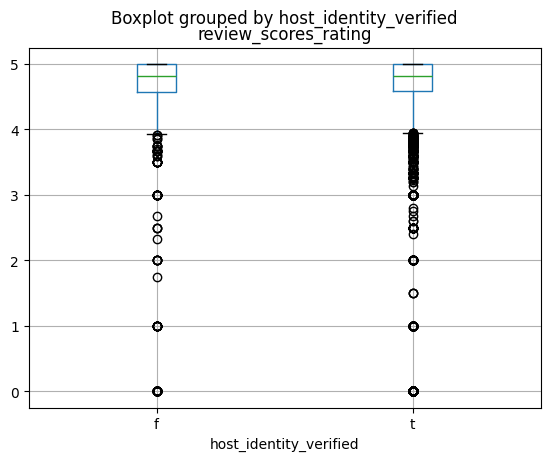

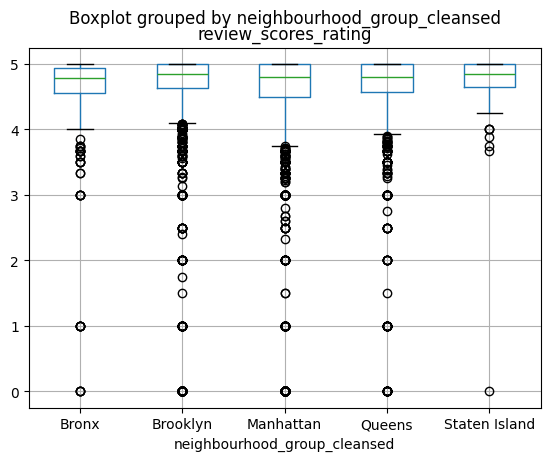

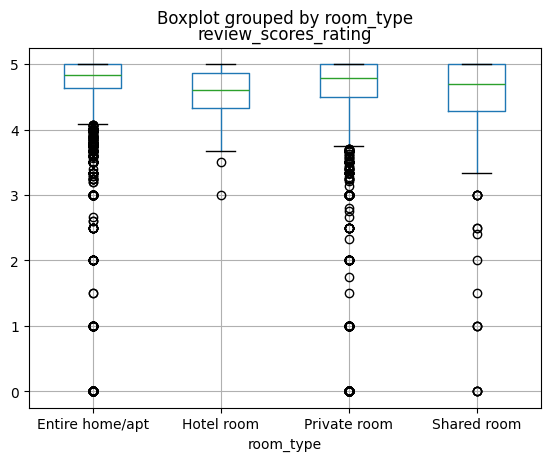

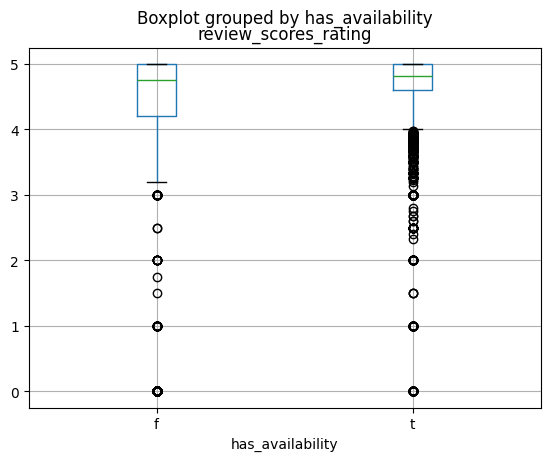

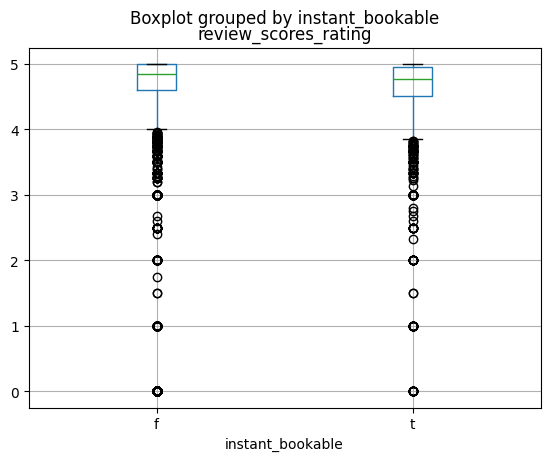

In [ ]:
boxplot_var = ['host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type', 'has_availability', 'instant_bookable']
for var in boxplot_var:
    train_df.boxplot(column="review_scores_rating", by=var)

Empirical P(Y=1|X=x) for categorical  variables:

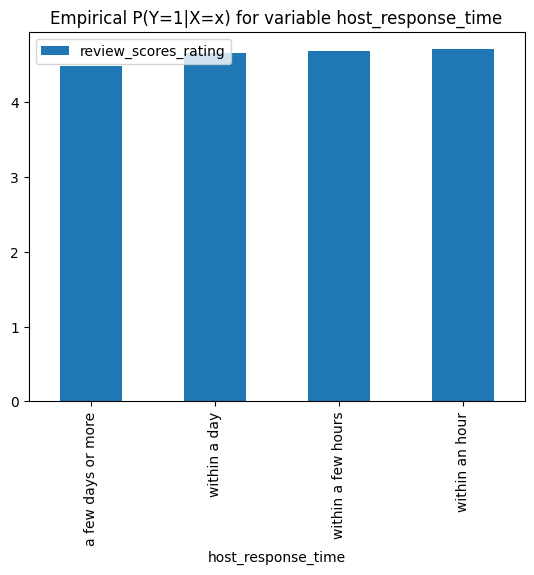

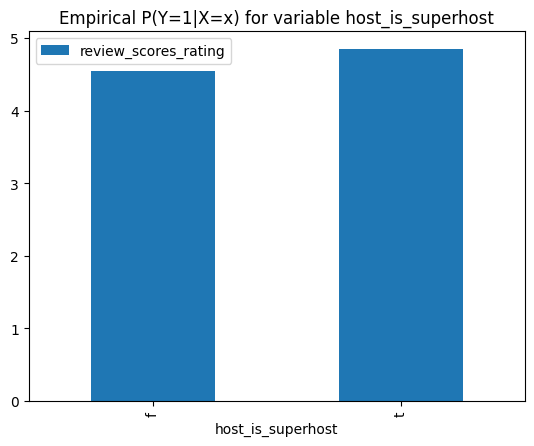

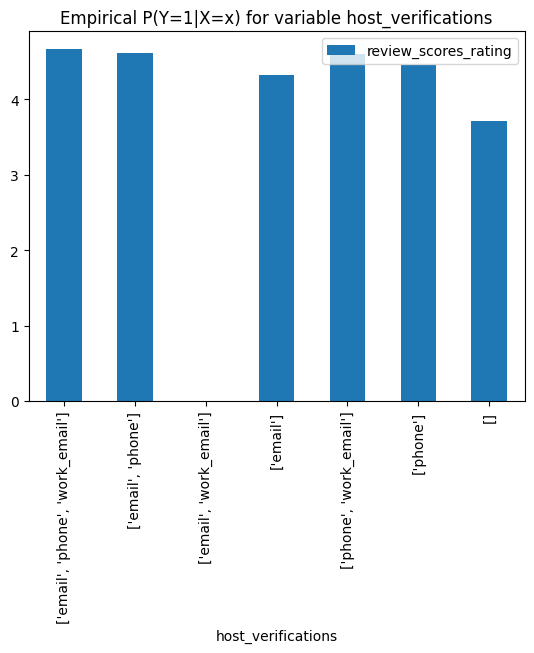

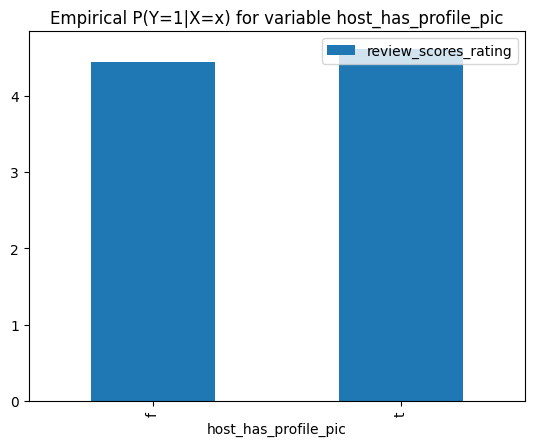

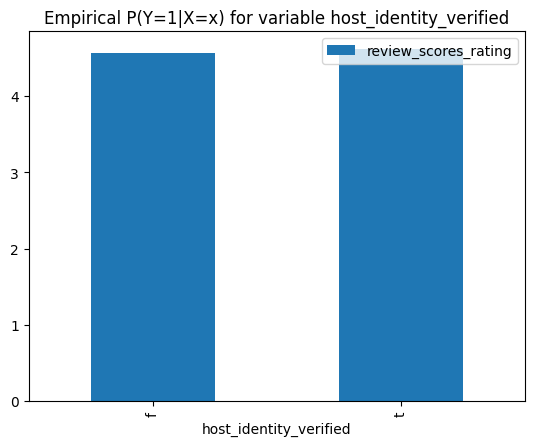

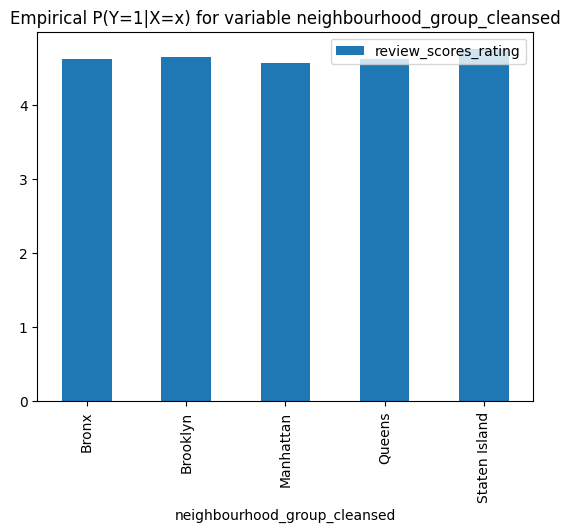

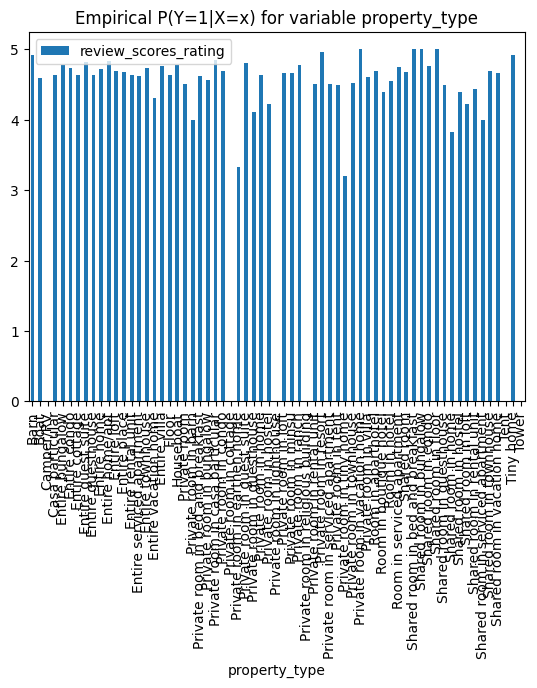

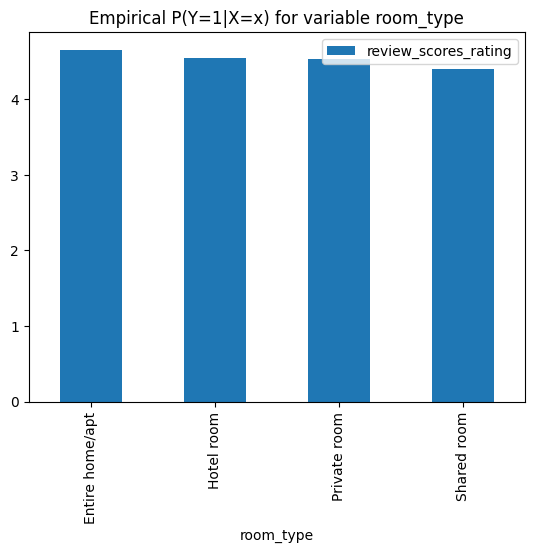

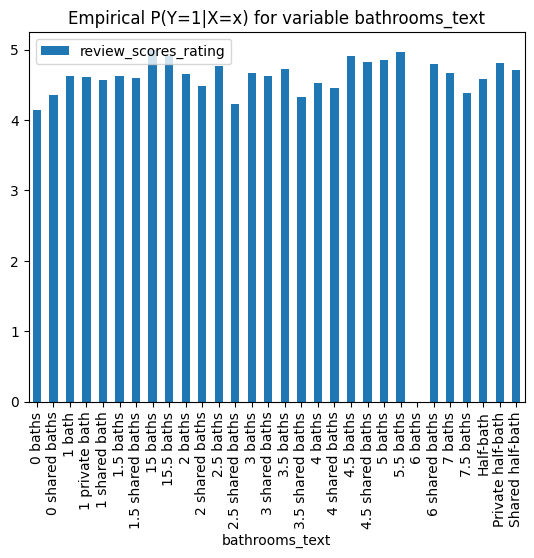

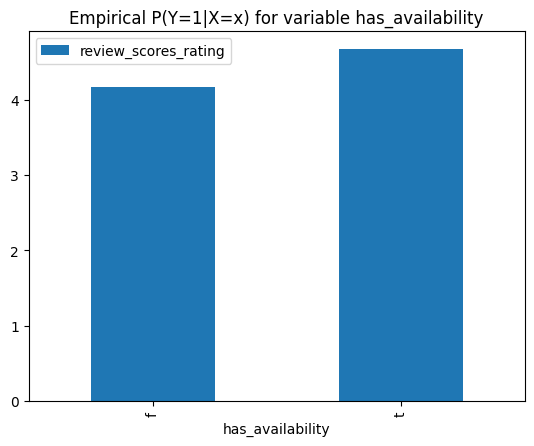

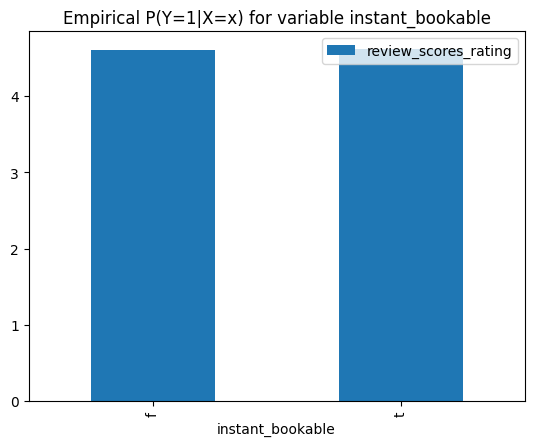

In [ ]:
for var in cat_var:
    train_df.groupby(var).agg({"review_scores_rating": "mean"}).plot(kind="bar", title=f"Empirical P(Y=1|X=x) for variable {var}")

Elementary data analysis using pandas-profiling:

In [ ]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(train_df, title="Data report train set")
#profile.to_notebook_iframe()

Questions:
*   Can you explain the observed patterns for Monthly_CPI, Monthly_CCI and Euribor3m?
*   What do you think of the data quality?
*   We have used the "train dataset" for the data analysis? Should we have included the "validation set" and "test set" as well? If not: should we carry out additional analyses?
*   Which variables do you consider promising for modelling?


## 2. Feature engineering

Build datasets with dummies for categorical variables:

In [12]:
cat_var = ['host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type', 'has_availability', 'instant_bookable']
def add_dummies(df, cat_var):
    """Return new dataframe with dummy variables for specified categorical variables."""
    dummies_df = pd.DataFrame()
    for var in cat_var:
        aux = pd.get_dummies(df[[var]], prefix=f"ind_{var}", drop_first=False)
        dummies_df = pd.concat([dummies_df, aux], axis=1)
    return dummies_df

def build_X_y(df, num_var, cat_var, name_target):
    """Build datasets X, y for modelling."""
    num_df = df.copy()[num_var]
    dum_df = add_dummies(df, cat_var)
    X = pd.concat([num_df, dum_df], axis=1)
    y = df[name_target]
    return X, y

name_target = "review_scores_rating"
X_train, y_train =  build_X_y(train_df, num_var, cat_var, name_target)
X_validation, y_validation =  build_X_y(validation_df, num_var, cat_var, name_target)
X_test, y_test =  build_X_y(test_df, num_var, cat_var, name_target)
# ensure common columns
cols = list(set(X_train.columns).intersection(set(X_validation.columns)).intersection(set(X_test.columns)))
X_train = X_train[cols]
X_validation = X_validation[cols]
X_test = X_test[cols]

### 2.1 Logit model

Available features:

In [13]:
print(X_train.columns)

Index(['ind_instant_bookable_t', 'ind_neighbourhood_group_cleansed_Queens',
       'ind_room_type_Private room', 'ind_host_has_profile_pic_f',
       'ind_host_identity_verified_t', 'calculated_host_listings_count',
       'review_scores_value',
       'ind_host_verifications_['email', 'phone', 'work_email']',
       'ind_has_availability_f',
       'calculated_host_listings_count_private_rooms', 'availability_30',
       'ind_neighbourhood_group_cleansed_Brooklyn', 'ind_has_availability_t',
       'beds', 'ind_room_type_Shared room',
       'ind_host_verifications_['phone', 'work_email']', 'price',
       'ind_host_identity_verified_f', 'host_response_rate',
       'ind_neighbourhood_group_cleansed_Bronx', 'host_listings_count',
       'number_of_reviews', 'ind_host_verifications_['email', 'phone']',
       'review_scores_accuracy', 'reviews_per_month', 'review_scores_rating',
       'ind_host_has_profile_pic_t', 'bedrooms', 'number_of_reviews_ltm',
       'review_scores_location', 'c

After the above shown preliminary data analysis and testing a few regression models, the following variables are selected for further anlysis of the regression model.

In [14]:
selected_features = ['longitude', 'host_response_rate', 'ind_neighbourhood_group_cleansed_Brooklyn',
       'beds', 'ind_room_type_Entire home/apt',
       'price', 'latitude', 'host_acceptance_rate',
       'number_of_reviews_ltm', 'bedrooms', 'ind_host_response_time_within an hour',
       'ind_host_has_profile_pic_t', 'ind_host_is_superhost_t',
       'host_listings_count', 'ind_has_availability_t']

First we fit a linear regression using the Scikit-learn package (for machine learning):

In [15]:
y_train_clean = y_train.dropna()
X_train_clean = X_train.loc[y_train_clean.index]

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_clean[selected_features])

linreg = LinearRegression()
linreg.fit(X_train_imputed, y_train_clean)

LinearRegression()

Create DataFrame of estimated coefficients:

In [16]:
est_coef = pd.DataFrame(linreg.coef_, index=selected_features, columns=["estimated coefficient"])
est_coef.loc["intercept"] = linreg.intercept_
display(est_coef)

,estimated coefficient
longitude,0.088937
host_response_rate,0.002767
ind_neighbourhood_group_cleansed_Brooklyn,0.041831
beds,-0.006692
ind_room_type_Entire home/apt,0.092138
price,0.000058
latitude,-0.220747
host_acceptance_rate,-0.001448
number_of_reviews_ltm,0.000607
bedrooms,-0.024679


The estimated probabilities Y=1:

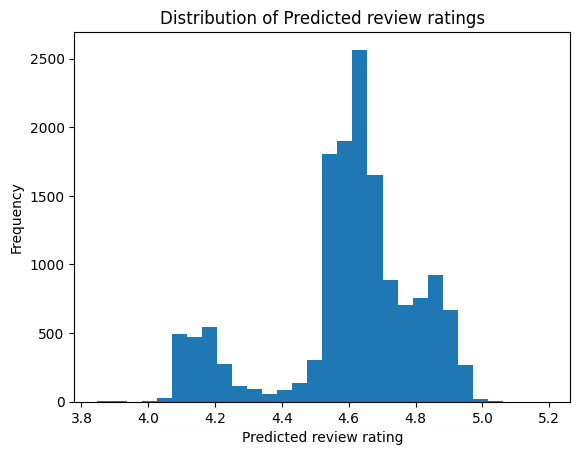

In [17]:
y_pred_train = linreg.predict(X_train_imputed)
plt.hist(y_pred_train, bins=30)
plt.xlabel("Predicted review rating")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted review ratings")
plt.show()

In [18]:
mse = mean_squared_error(y_train_clean, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_clean, y_pred_train)

print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.3f}")

RMSE: 0.74
R² score: 0.073


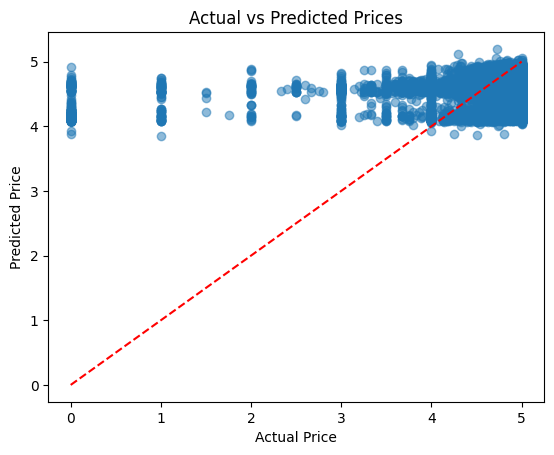

In [19]:
plt.scatter(y_train_clean, y_pred_train, alpha=0.5)
plt.plot([y_train_clean.min(), y_train_clean.max()], [y_train_clean.min(), y_train_clean.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()

**Question**: evaluate performance on validation set

#### Decision tree

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=40)
model_tree = clf.fit(X_train, y_train)
ax = plt.figure(figsize=(25, 25))
tree.plot_tree(model_tree, max_depth=3, filled=True, fontsize=10)

In [ ]:
hat_target_train_tree = model_tree.predict(X_train)

plot_confusion_matrix(hat_target_train_tree, y_train, [0, 1])
plot_roc(y_train,  model_tree.predict_proba(X_train)[:, 1] )

**Question:** evaluate performance on the validation set

Question:  investigate impact of the 'max_depth' parameter.

### Random forest

In [ ]:
clf = RandomForestClassifier(n_estimators=250, random_state=123)
rf = clf.fit(X_train, y_train)

In [ ]:
hat_target_train_rf = rf.predict(X_train)

plot_confusion_matrix(hat_target_train_rf, y_train, [0, 1])
plot_roc(y_train,  rf.predict_proba(X_train)[:, 1] )

**Question:** investigate performance on the validation set.

**Question:** Consider the documentation of Scikit and investigate impact of max_depth.

### Xgboost

In [26]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train_imputed, y_train_clean)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

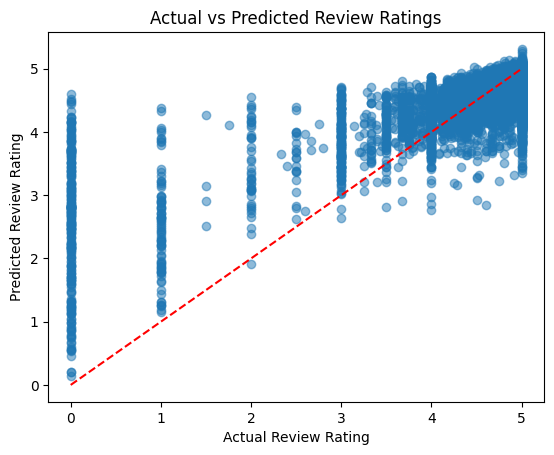

RMSE: 0.494
R²: 0.592


In [28]:
hat_target_train_xgb = xgb_model.predict(X_train_imputed)

# Scatter plot of actual vs predicted
plt.scatter(y_train_clean, hat_target_train_xgb, alpha=0.5)
plt.plot([y_train_clean.min(), y_train_clean.max()],
         [y_train_clean.min(), y_train_clean.max()],
         'r--')
plt.xlabel("Actual Review Rating")
plt.ylabel("Predicted Review Rating")
plt.title("Actual vs Predicted Review Ratings")
plt.show()

# Optional: Print metrics
mse = mean_squared_error(y_train_clean, hat_target_train_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_clean, hat_target_train_xgb)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

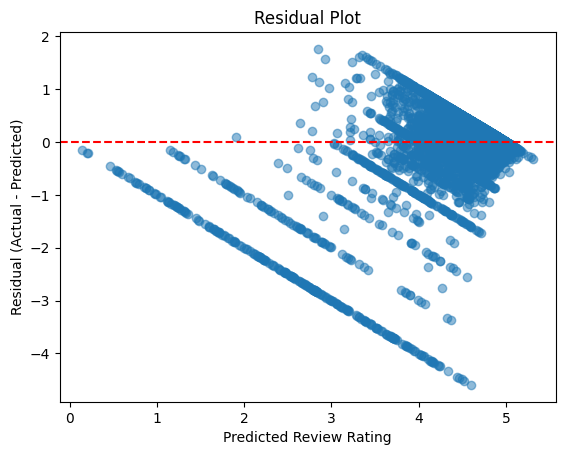

In [29]:
residuals = y_train_clean - hat_target_train_xgb

plt.scatter(hat_target_train_xgb, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Review Rating")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

**Question**: determine performance on validation set

In [30]:
#hat_target_train_xgb = xgb.predict(X_validation)
#plot_confusion_matrix(hat_target_train_xgb, y_validation, [0, 1])
#plot_roc(y_validation, xgb.predict_proba(X_validation)[:, 1] )

hat_target_train_xgb = xgb_model.predict(X_validation)

# Scatter plot of actual vs predicted
plt.scatter(y_validation, hat_target_train_xgb, alpha=0.5)
plt.plot([y_validation.min(), y_validation.max()],
         [y_validation.min(), y_validation.max()],
         'r--')
plt.xlabel("Actual Review Rating")
plt.ylabel("Predicted Review Rating")
plt.title("Actual vs Predicted Review Ratings")
plt.show()

# Optional: Print metrics
mse = mean_squared_error(y_validation, hat_target_train_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_validation, hat_target_train_xgb)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:price: object, host_response_rate: object, host_acceptance_rate: object